# Visualising the top European cities for Data Science jobs

The following code generates a bar chart and maps of Data Science job offers across European cities in three main steps:

[1] Web Scraping: visit job search engine careerjet.com and gather the total number of Data Science job offers per city

[2] Visualisation: create a bar chart of the top 20 cities (Europe)

[3] Geographical Plotting: plot top cities onto maps (Europe, United Kingdom, France, Germany, The Netherlands)

First, let's import relevant libraries.

In [1]:
%matplotlib inline
# plot figures inline

# IMPORT LIBRARIES
from bs4 import BeautifulSoup # parsing
from mpl_toolkits.basemap import Basemap # geographical plotting

import datetime # working with dates
import matplotlib # plotting
import matplotlib.pyplot as plt # plotting
import pandas as pd # data manipulation and analysis
import time # working with time
import urllib.request # working with URLs

Then, a list of European cities is generated.

In [2]:
# LOAD COUNTRY AND CITY DATA
countries = pd.read_csv('countries.csv') # adapted from https://developers.google.com/public-data/docs/canonical/countries_csv
cities = pd.read_csv('worldcities.csv') # 'Basic' database at https://simplemaps.com/data/world-cities

# PREPARE DATAFRAME
cities = cities.loc[:,['city_ascii','country','lat','lng','population']] # retain relevant columns
cities = cities.replace('Czechia', 'Czech Republic') # rename country with alternative name
cities = cities.replace('Macedonia', 'North Macedonia') # rename country with alternative name
cities = cities[cities.country.isin(list(countries.country))] # retain European cities
cities = cities[cities.population>100000] # filter cities with at least 100,000 inhabitants

# PRINT SAMPLE INFORMATION
print('\nTotal number of cities: '+str(len(cities))) # print count of cities
print('\nExample: Austria, ' # print example country
      +str(len(cities[cities.country=='Austria']))+' cities ' # print count of cities for example country
      +str(list(cities[cities.country=='Austria']['city_ascii']))) # print cities for example country


Total number of cities: 438

Example: Austria, 5 cities ['Innsbruck', 'Salzburg', 'Linz', 'Graz', 'Vienna']


Next, a list of careerjet.com URLs is created, using English search terms "Data Science" and "Data Scientist". Search terms in other languages − e.g. "Science des données" in French or "Ciencia de datos" in Spanish − showed limited results in testing and were hence not included.

In [3]:
# PREPARE STRING ELEMENTS
URL_base = 'https://www.careerjet.com/search/jobs?s="Data+Science"+OR+"Data+Scientist"&l=' # beginning of URL
URL_city = list(cities.city_ascii) # city
URL_cntr = list(cities.country) # country

# CONCATENATE STRING ELEMENTS INTO URLS
URLs = [] # create empty list

for i in range(0,len(cities)): # for all cities
    URLs.append(URL_base # concatenate beginning of URL with
                +URL_city[i].replace(' ', '+') # city (with any blank space as '+')
                +'+' # '+'
                +URL_cntr[i].replace(' ', '+') # country (with any blank space as '+')
                +'&radius=1' # radius of search outside city in miles
               ) # append the URL to the list

# PRINT SAMPLE INFORMATION
print('\nExample: '+URLs[365]) # print URL for example city


Example: https://www.careerjet.com/search/jobs?s="Data+Science"+OR+"Data+Scientist"&l=London+United+Kingdom&radius=1


Now, each URL is consulted to gather the total number of job offers per city. (Please note this part of the code takes a few minutes to run.)

In [4]:
# SCRAPE URLs
temp_list = [] # create empty list

for i in range(0,len(URLs)): # for all URLs
    response = urllib.request.urlopen(URLs[i], timeout=60) # open URL
    html = response.read() # read contents
    soup = BeautifulSoup(html,'lxml') # parse contents
    temp = soup.find_all('span', class_='display_results display_inline') # retrieve count of job offers for city
    
    if temp == []: # if there are 0 jobs
        temp = 0 # count as 0

    elif str(temp) == '[<span class="display_results display_inline"><nobr>1 job</nobr></span>]': # if there is 1 job 
        temp = 1 # count as 1

    else: # if there are n jobs, retrieve count of job offers n
        temp = str(temp) # convert to string
        start_i = temp.find('of ')+3 # identify start index
        stop_i = temp.find(' jobs</nobr></span>]') # identify stop index
        temp = int(temp[start_i:stop_i]) # return string from start to stop index as an integer
    
    temp_list.append(temp) # append count of job offers to list
    
    time.sleep(1) # wait for 1 second between each iteration

cities['offer_count'] = temp_list # add count of job offers to dataframe
cities = cities[cities['offer_count']>0] # retain cities with 1 or more job offers
cities.reset_index(inplace=True) # reset dataframe index
cities = cities.drop('index', 1) # remove 'index' column

# PRINT SAMPLE INFORMATION
print('\nExample:\n') # print example
print(cities.head(3)) # print first 3 rows of dataframe


Example:

   city_ascii     country      lat      lng  population  offer_count
0     Vilnius   Lithuania  54.6834  25.3166    542366.0            6
1  Luxembourg  Luxembourg  49.6117   6.1300    107260.0           51
2        Riga      Latvia  56.9500  24.1000    742572.0            4


With the information gathered, we can take a first look at the results using a horizontal bar chart.

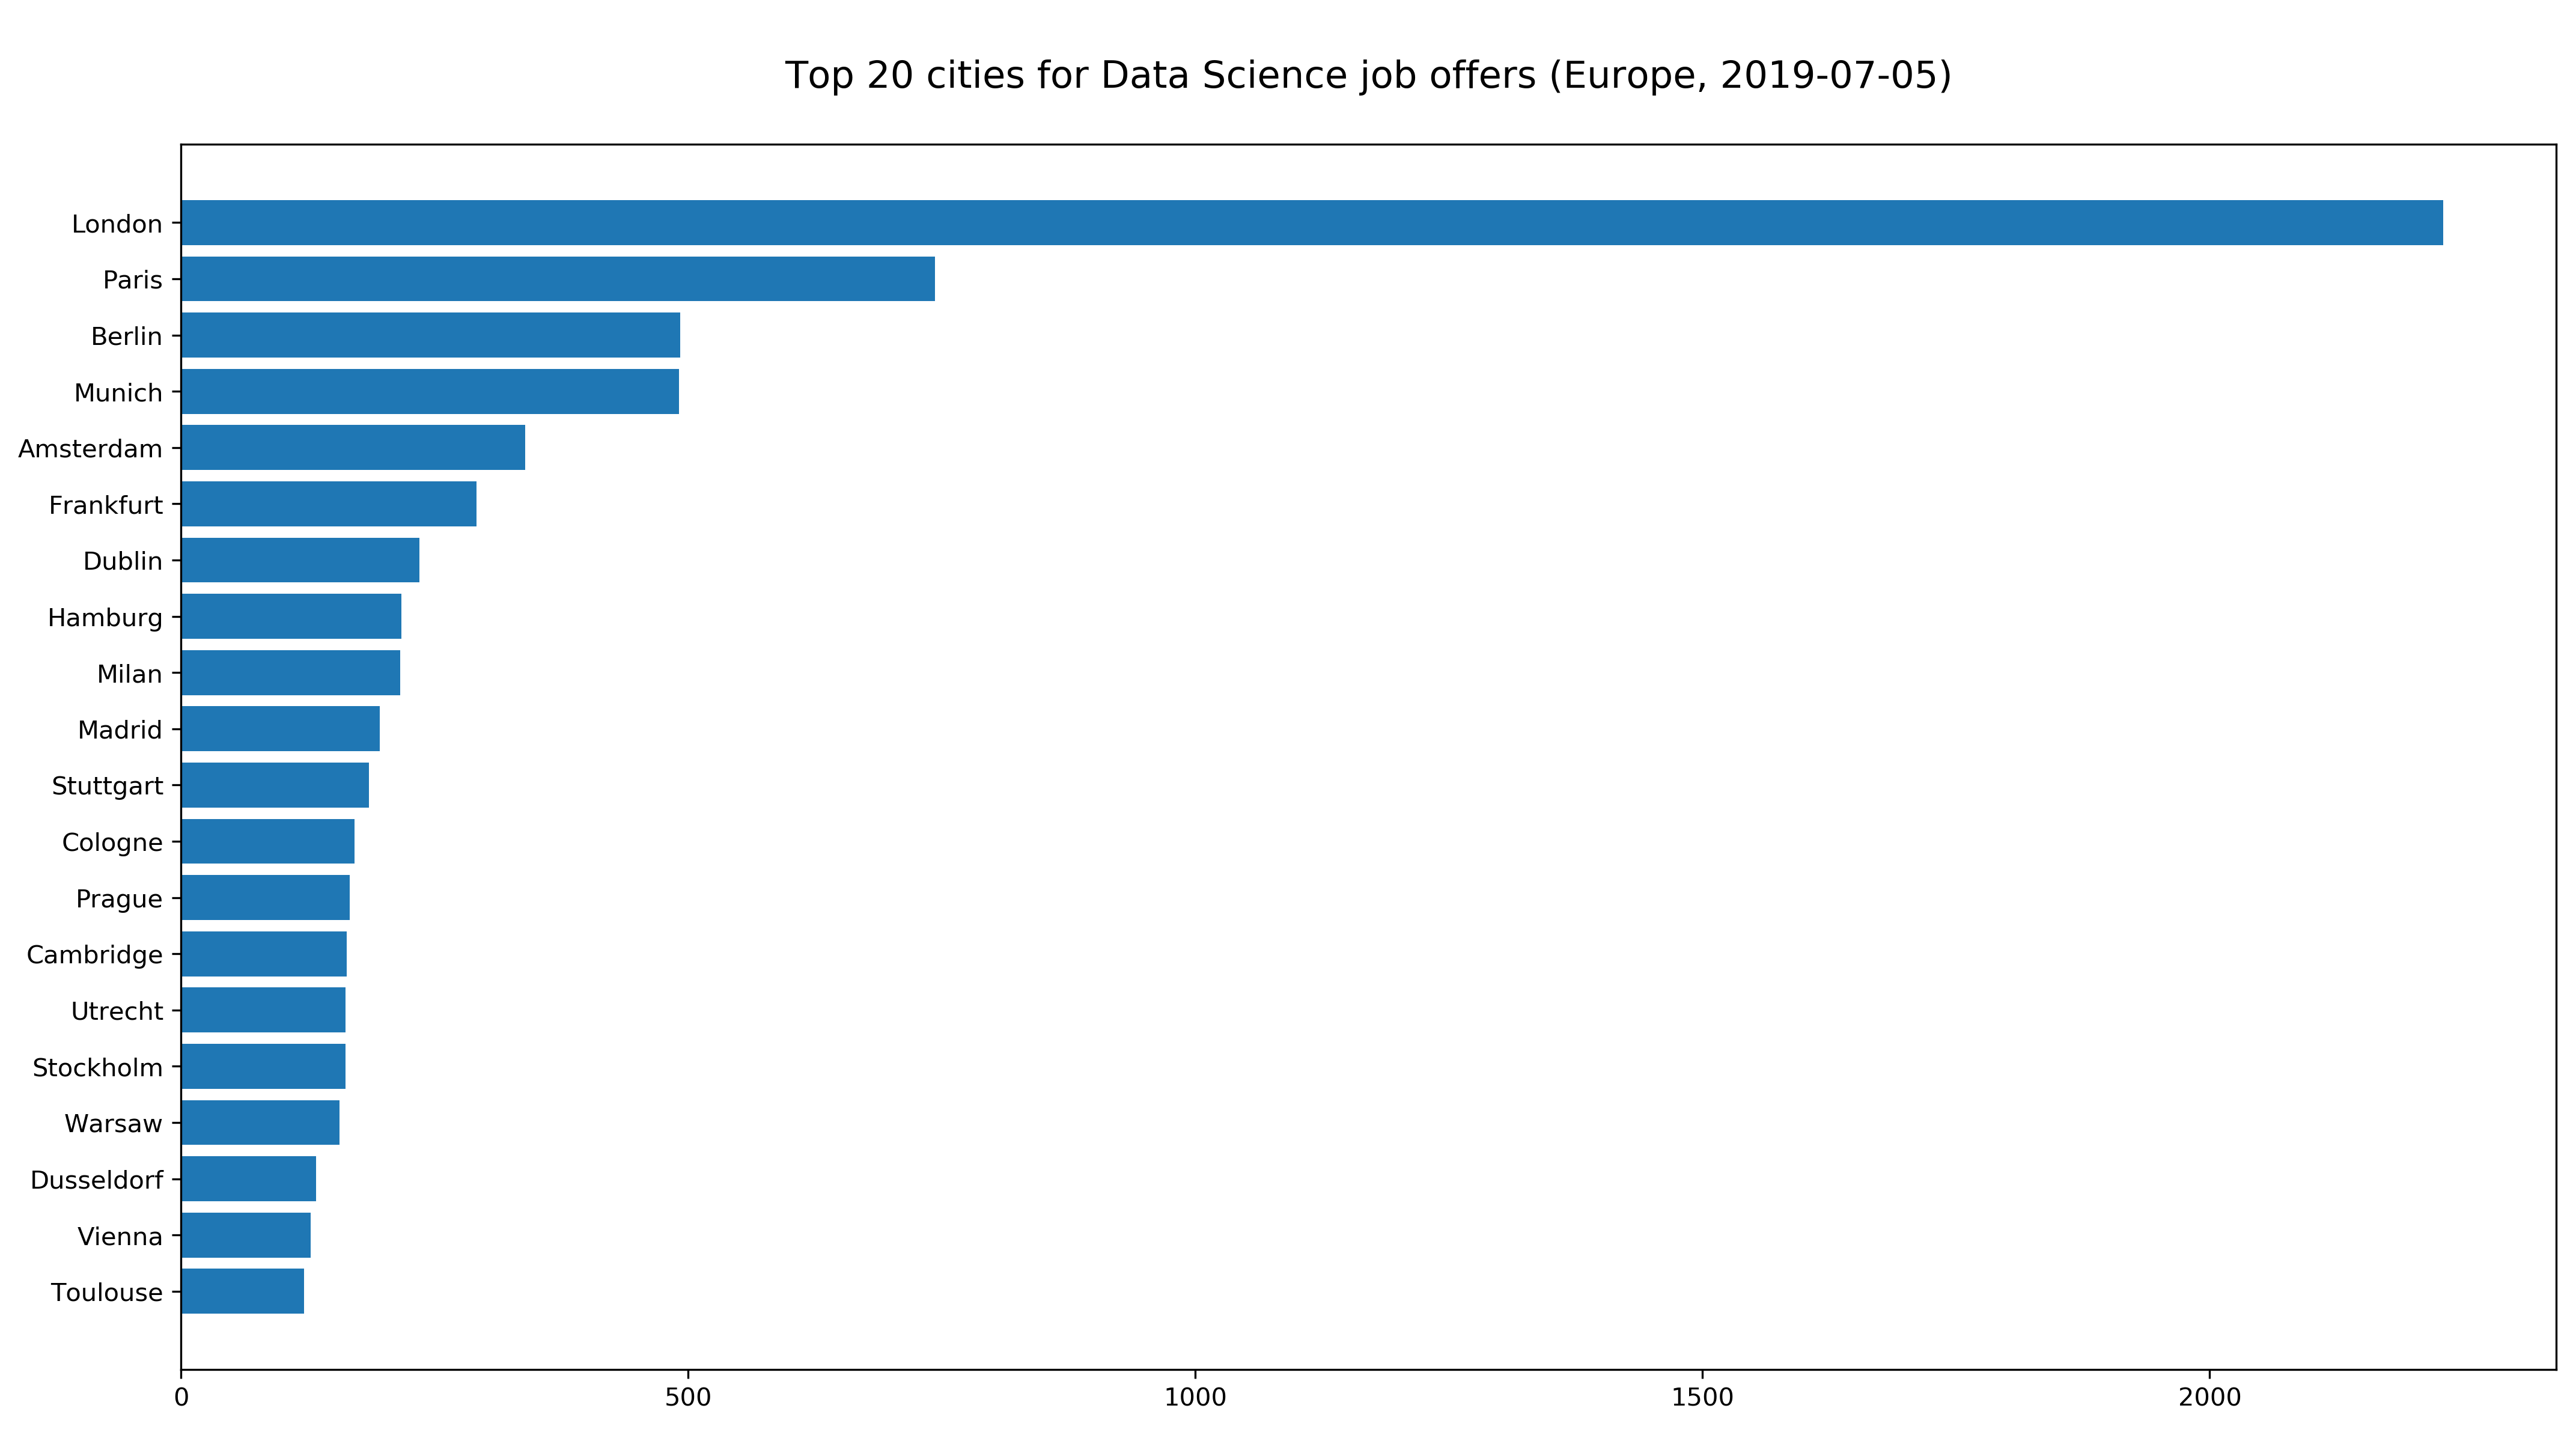

In [5]:
# PREPARE DATA
top_20_europe = cities.nlargest(20, 'offer_count').sort_values('offer_count', ascending=True) # subset top 20 cities

# PREPARE BAR CHART
matplotlib.rcParams['figure.dpi'] = 300 # set display resolution
fig=plt.figure(figsize=(17, 9), facecolor='w', edgecolor='k') # prepare figure
plt.barh(top_20_europe.city_ascii, top_20_europe.offer_count) # prepare bar chart
plt.title('\nTop 20 cities for Data Science job offers (Europe, '+datetime.datetime.now().strftime('%Y-%m-%d')+')\n', # title
          fontsize=15) # title font size

# PLOT AND SAVE BAR CHART AS .PNG IN CURRENT WORKING DIRECTORY
plt.show() # show figure
fig.savefig('Top 20 cities for Data Science job offers (Europe, ' # format .png file name
            +datetime.datetime.now().strftime('%Y-%m-%d')+', bar chart).png', # include date
            dpi=300, # set output resolution
            bbox_inches='tight' # remove blank spaces around figure
           ) # save figure as .png

To be able to plot job offer information onto maps with flexibility, we now define a function.

In [6]:
# DEFINE FUNCTION TO VISUALISE SUBSET
def visualise_subset(lllon, lllat, urlon, urlat, fig_width, fig_height, geo, top_n): # define function and parameters
    
    # SUBSET GEOGRAPHICALLY
    if geo == 'Europe': # if region is Europe
        subset = cities # then subset is the entire dataframe
    else: # otherwise
        subset = cities[cities.country==geo] # subset is data for a particular country
    
    # SUBSET TOP N CITIES
    subset = subset.nlargest(top_n, 'offer_count') # retain top n cities
    
    # CALCULATE RELATIVE MARKER SIZE
    sizs = list((subset.offer_count/max(subset.offer_count))*4000) # set marker size depending on count of jobs offers
    subset = subset.assign(sizs=sizs) # add marker sizes to dataframe
    
    # DRAW MAP
    matplotlib.rcParams['figure.dpi'] = 300 # set display resolution
    fig = plt.figure(figsize=(fig_width, fig_height)) # set width and height of figure in inches
    
    m = Basemap(projection='mill', # see https://matplotlib.org/basemap/users/mapsetup.html
                resolution='i', # 'None', 'c'rude, 'l'ow, 'i'ntermediate, 'h'igh or 'f'ull
                llcrnrlon=lllon, # lower left hand corner longitude
                llcrnrlat=lllat, # lower left hand corner latitude
                urcrnrlon=urlon, # upper right hand corner longitude
                urcrnrlat=urlat # upper right hand corner latitude
                )
    
    m.drawcoastlines(linewidth=.5, color='grey') # draw coastlines
    m.drawcountries(linewidth=.5, color='grey') # draw country boundaries
    m.drawmapboundary(fill_color='#46bcec', zorder=-1) # set sea/ocean colour
    m.fillcontinents(color='#f2f2f2', lake_color='#46bcec', zorder=0) # set land and lake colours

    # ANNOTATE COUNTRY NAME
    if geo == 'Europe': # if region is Europe
        country_anno = countries # then subset is all European countries
        skip_anno = ['Albania',
                     'Bosnia And Herzegovina',
                     'Cyprus',
                     'Finland',
                     'Luxembourg',
                     'Malta',
                     'Moldova',
                     'Montenegro',
                     'Netherlands',
                     'North Macedonia',
                     'Portugal',
                     'Switzerland'
                     ] # minus countries whose names do not display well on a map of this size
        country_anno = country_anno[-country_anno.country.isin(skip_anno)] # subset country names
        font_size = 8 # set font size
    else: # otherwise
        country_anno = countries[countries.country==geo]  # subset is data for a particular country
        font_size = 10 # set font size
    
    for i in range(0,len(country_anno)): # for all countries
            plt.annotate(list(country_anno.country)[i].upper(), # annotate country name
                         m(list(country_anno.lon)[i],list(country_anno.lat)[i]), # at latitude, longitude
                         fontsize=font_size, # font size
                         color='grey', # colour
                         ha='center', # horizontal alignment
                         va='center' # vertical alignment
                         )
    
    # PLOT CITIES
    m.scatter(list(subset.lng), # longitudes
              list(subset.lat), # latitudes
              latlon=True, # treat the above as geographical coordinates
              s=list(subset.sizs), # marker sizes
              c='saddlebrown', # colour
              alpha=.5, # transparency
              label='City (Number of job offers)' # label
              )

    # ANNOTATE CITY NAMES AND COUNT OF OFFERS
    for i in range(0,len(subset)): # for all cities in subset
        plt.annotate(list(subset.city_ascii)[i]+' ('+str(list(subset.offer_count)[i])+')', # annotate city (count of job offers)
                     m(list(subset.lng)[i],list(subset.lat)[i]), # at latitude, longitude
                     fontsize=10, # font size
                     ha='center', # horizontal alignment
                     va='center', # vertical alignment
                     )
    
    # PLOT MAP AND SAVE IT AS .PNG IN CURRENT WORKING DIRECTORY
    map_title = '\nTop ' + str(top_n) + ' cities for Data Science job offers (' + geo +\
              ', ' + datetime.datetime.now().strftime('%Y-%m-%d')+ ')\n' # format map title and include date
    plt.title(map_title, fontsize=15) # display title
    plt.legend(loc='lower right', markerscale=.25) # display legend
    plt.show() # plot figure
    fig.savefig(map_title.replace('\n','').replace(')','')+', map).png', dpi=300, bbox_inches='tight') # save as .png

Finally, the job offers are plotted onto maps as bubbles. The larger the bubble, the more Data Science job offers in that city.

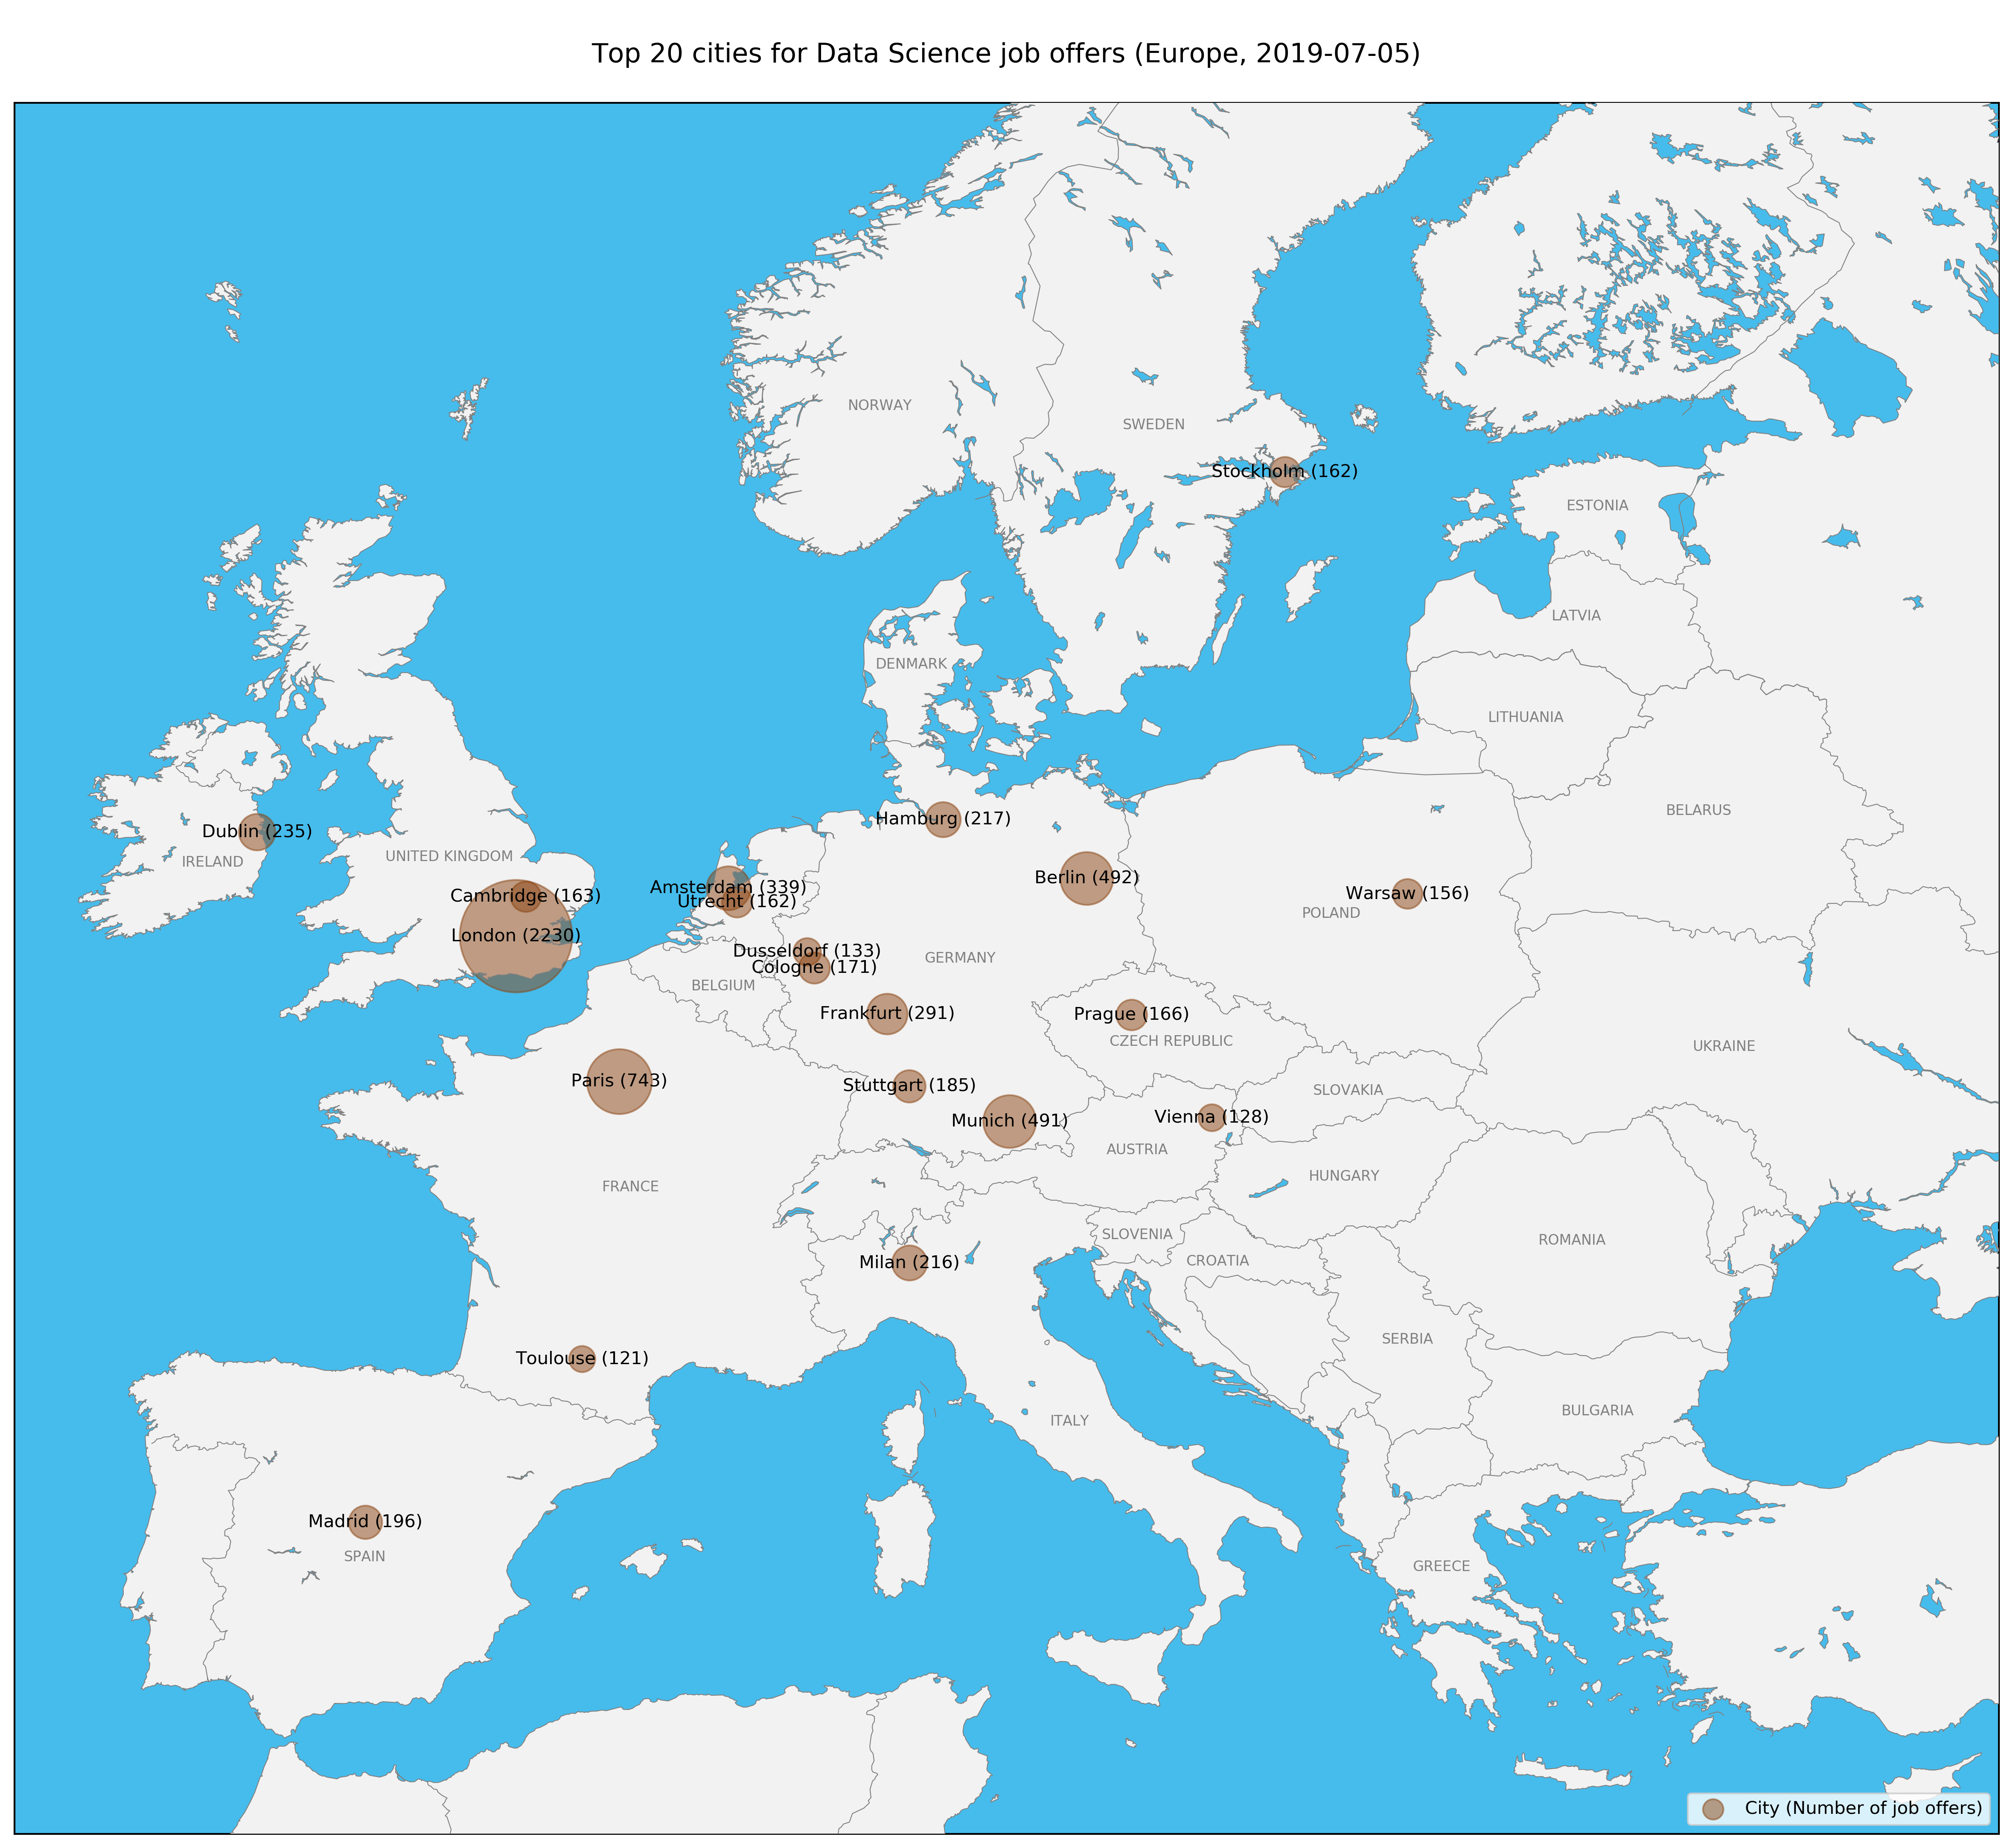

In [7]:
# VISUALISE THE TOP 20 CITIES FOR DATA SCIENCE JOB OFFERS IN EUROPE
visualise_subset(lllon=-12, lllat=34, urlon=35, urlat=65, fig_width=20, fig_height=20, geo='Europe', top_n=20)

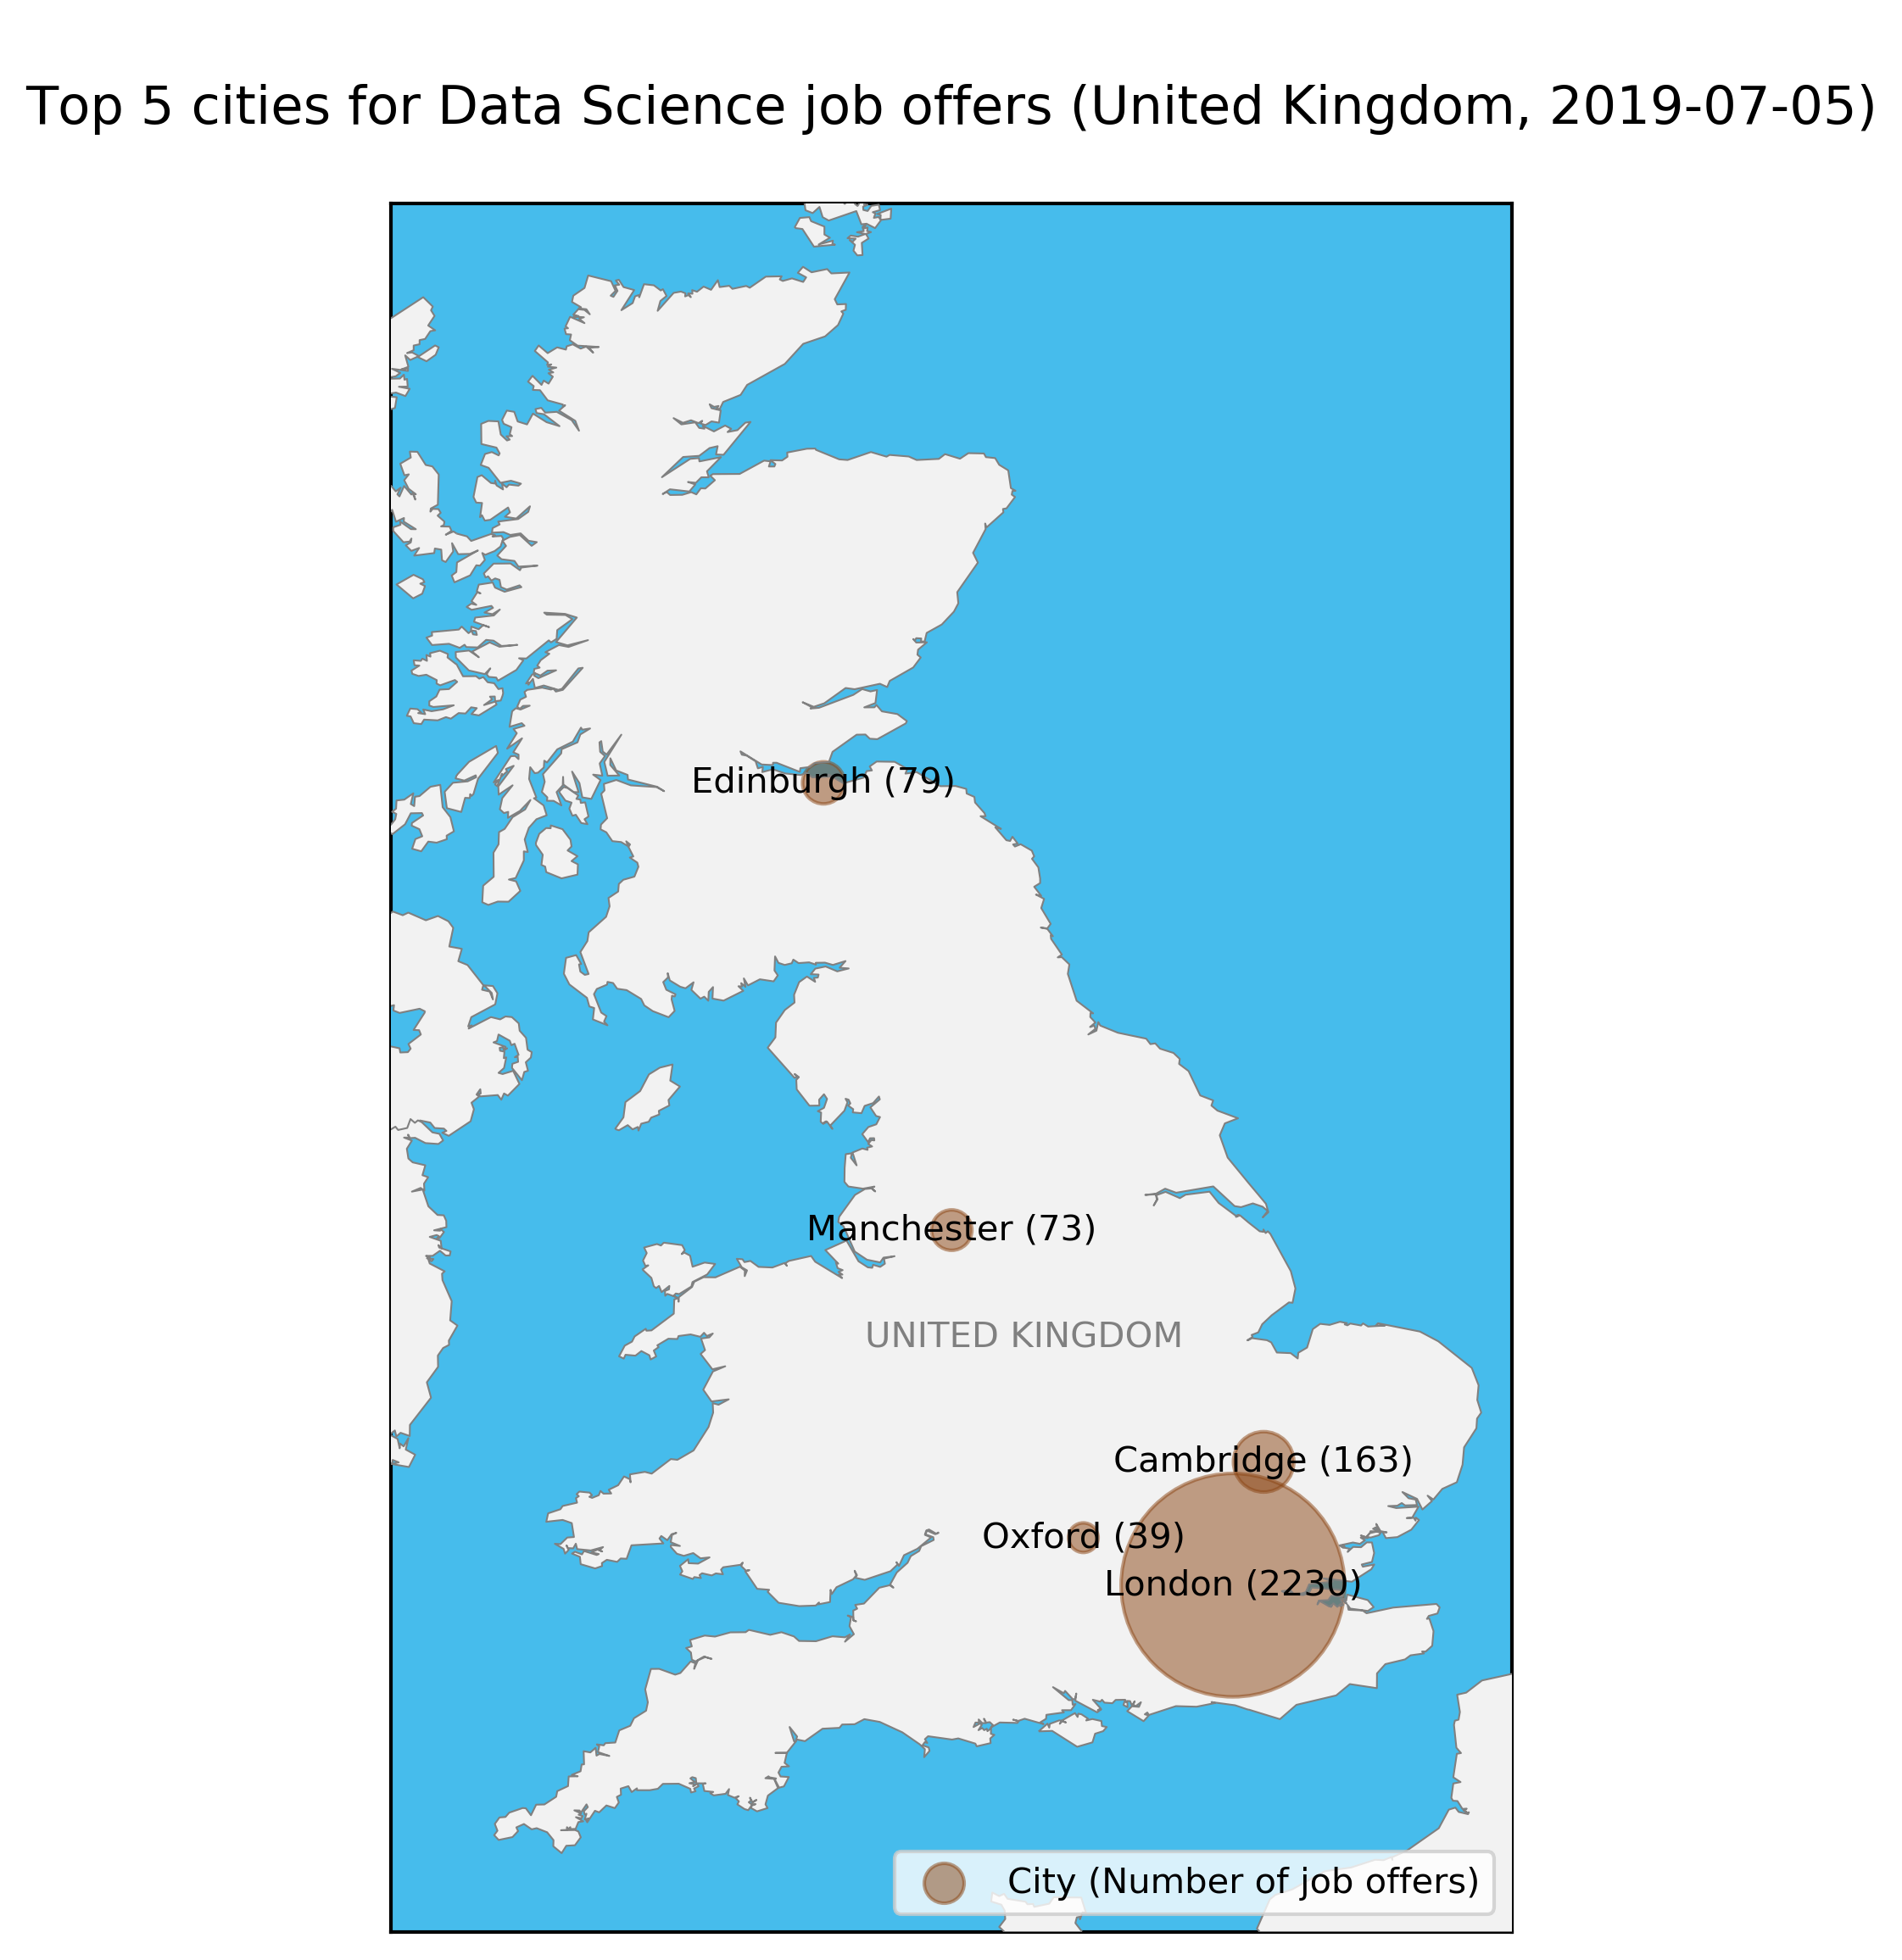

In [8]:
# VISUALISE THE TOP 5 CITIES FOR DATA SCIENCE JOB OFFERS IN THE UNITED KINGDOM
visualise_subset(lllon=-6.5, lllat=49.5, urlon=2, urlat=59, fig_width=9, fig_height=9, geo='United Kingdom', top_n=5)

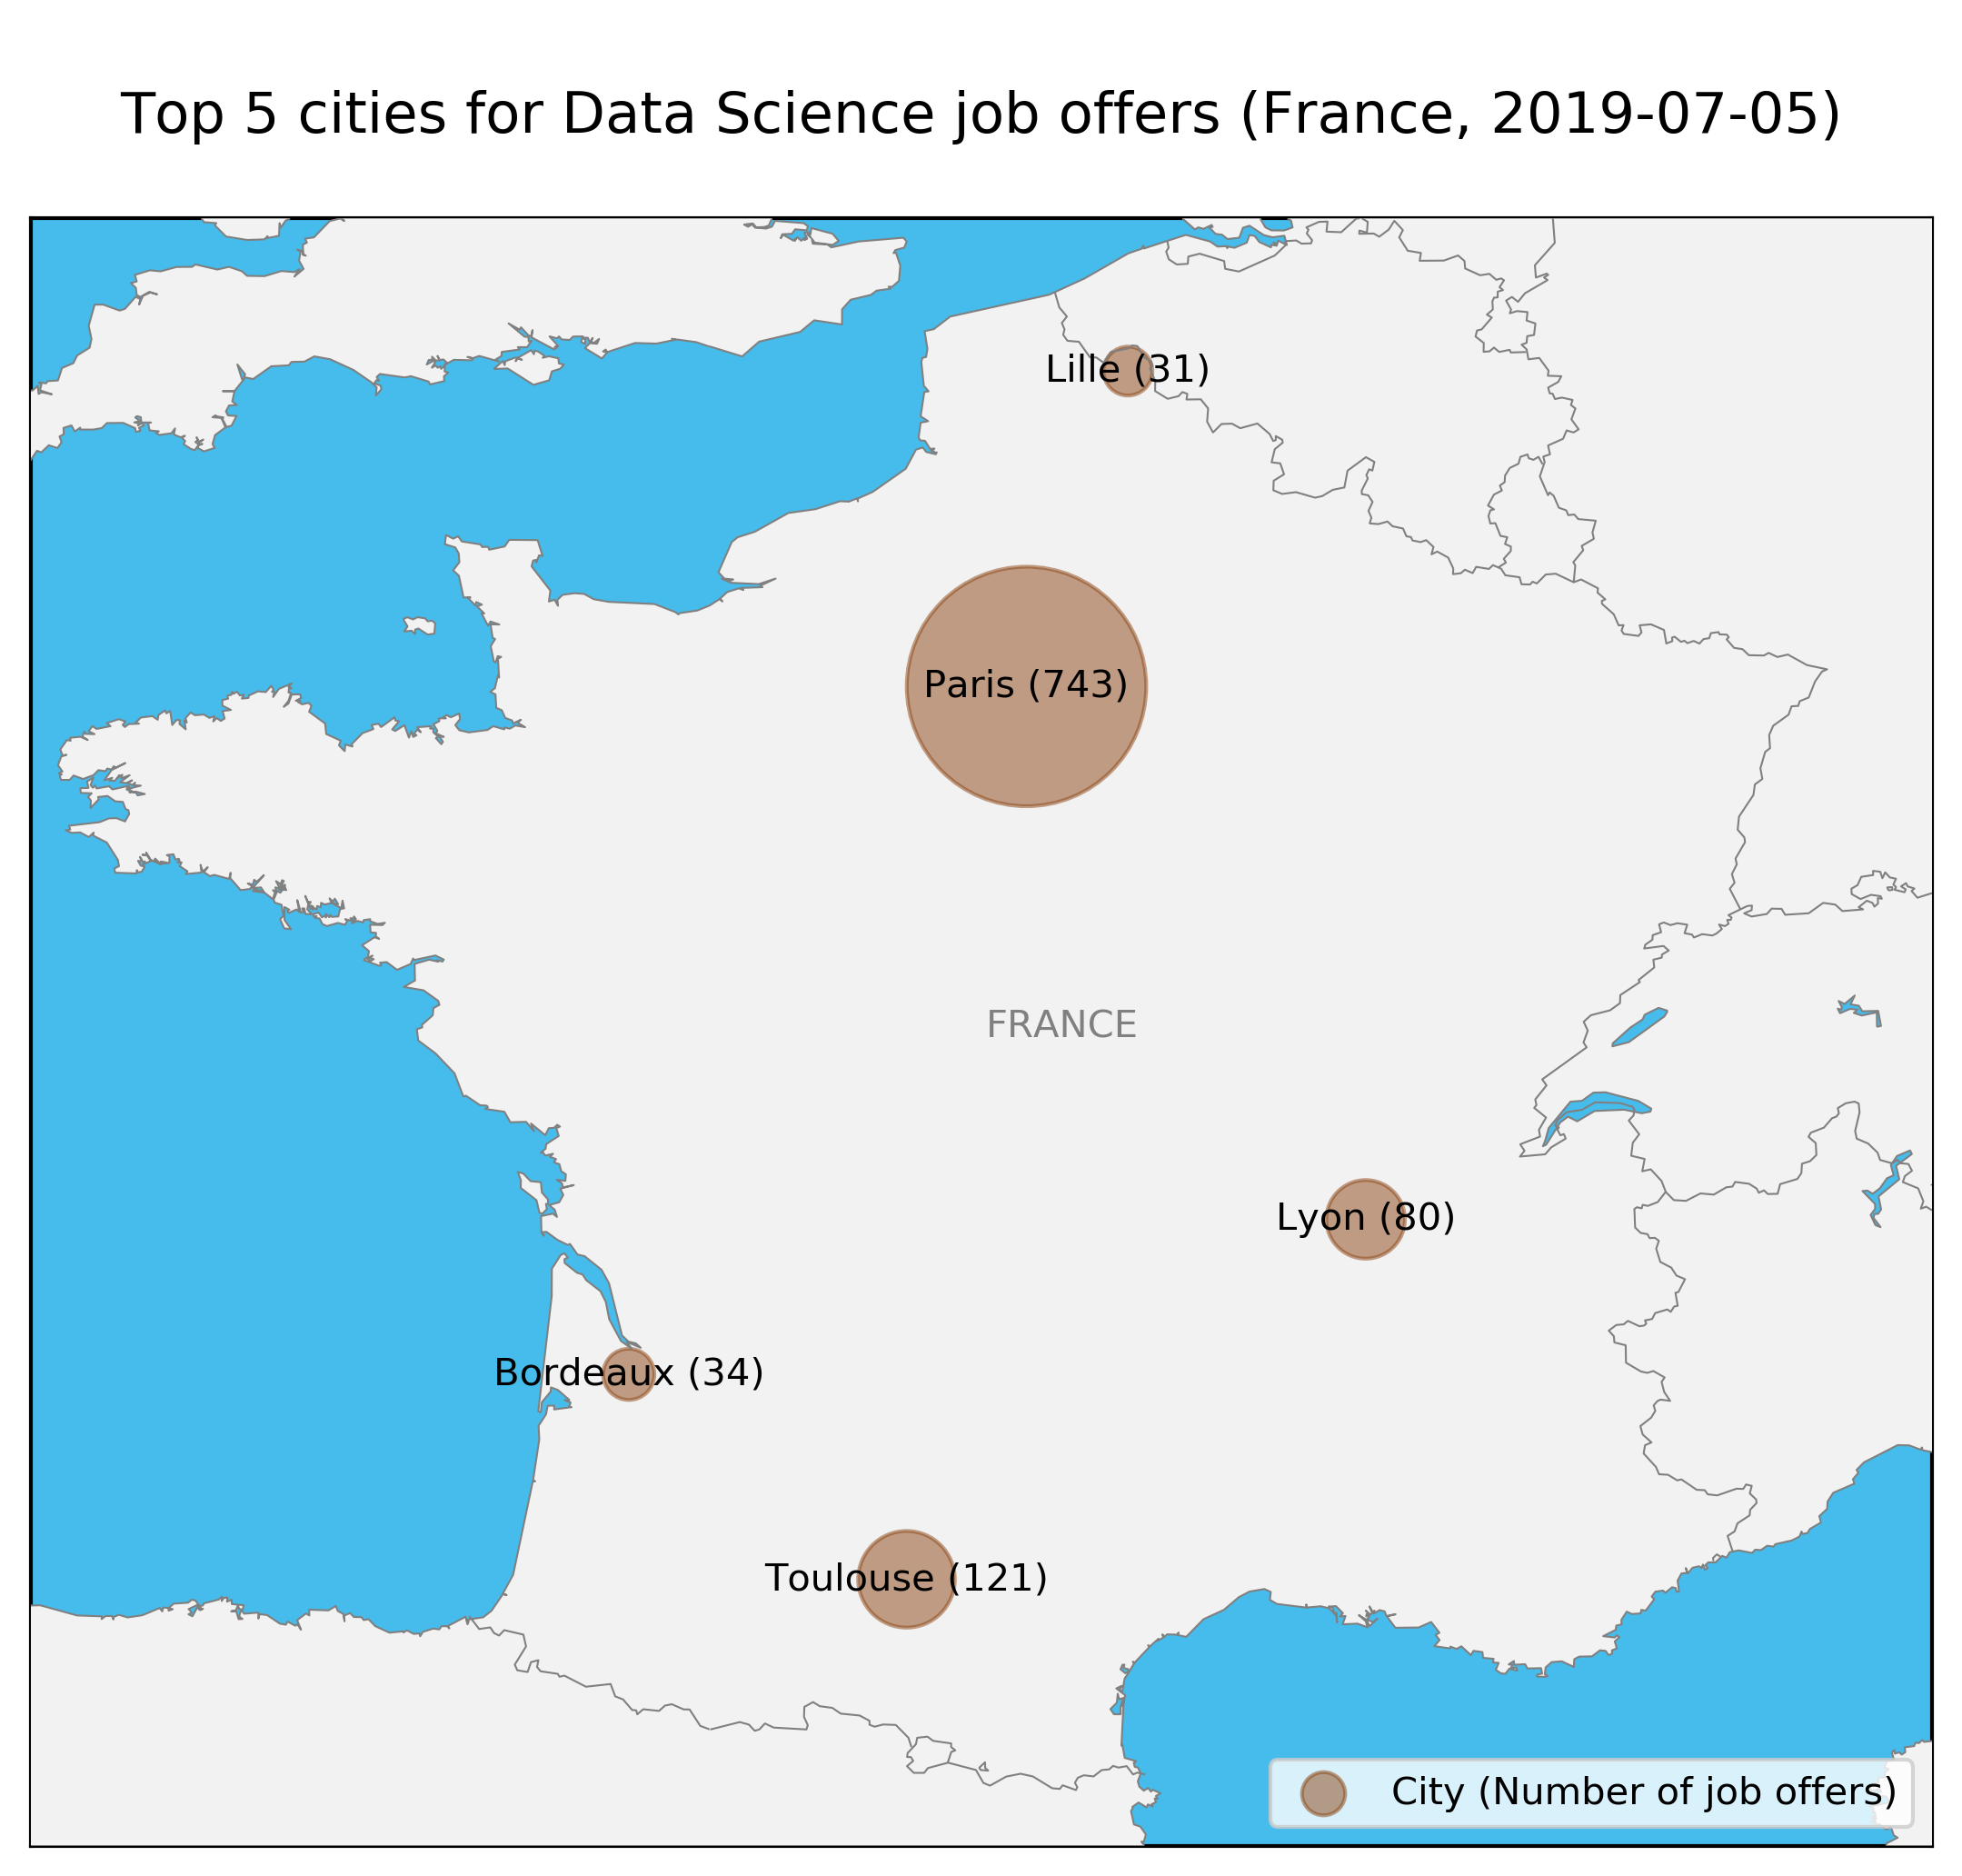

In [9]:
# VISUALISE THE TOP 5 CITIES FOR DATA SCIENCE JOB OFFERS IN FRANCE
visualise_subset(lllon=-5, lllat=42, urlon=9, urlat=51.5, fig_width=9, fig_height=9, geo='France', top_n=5)

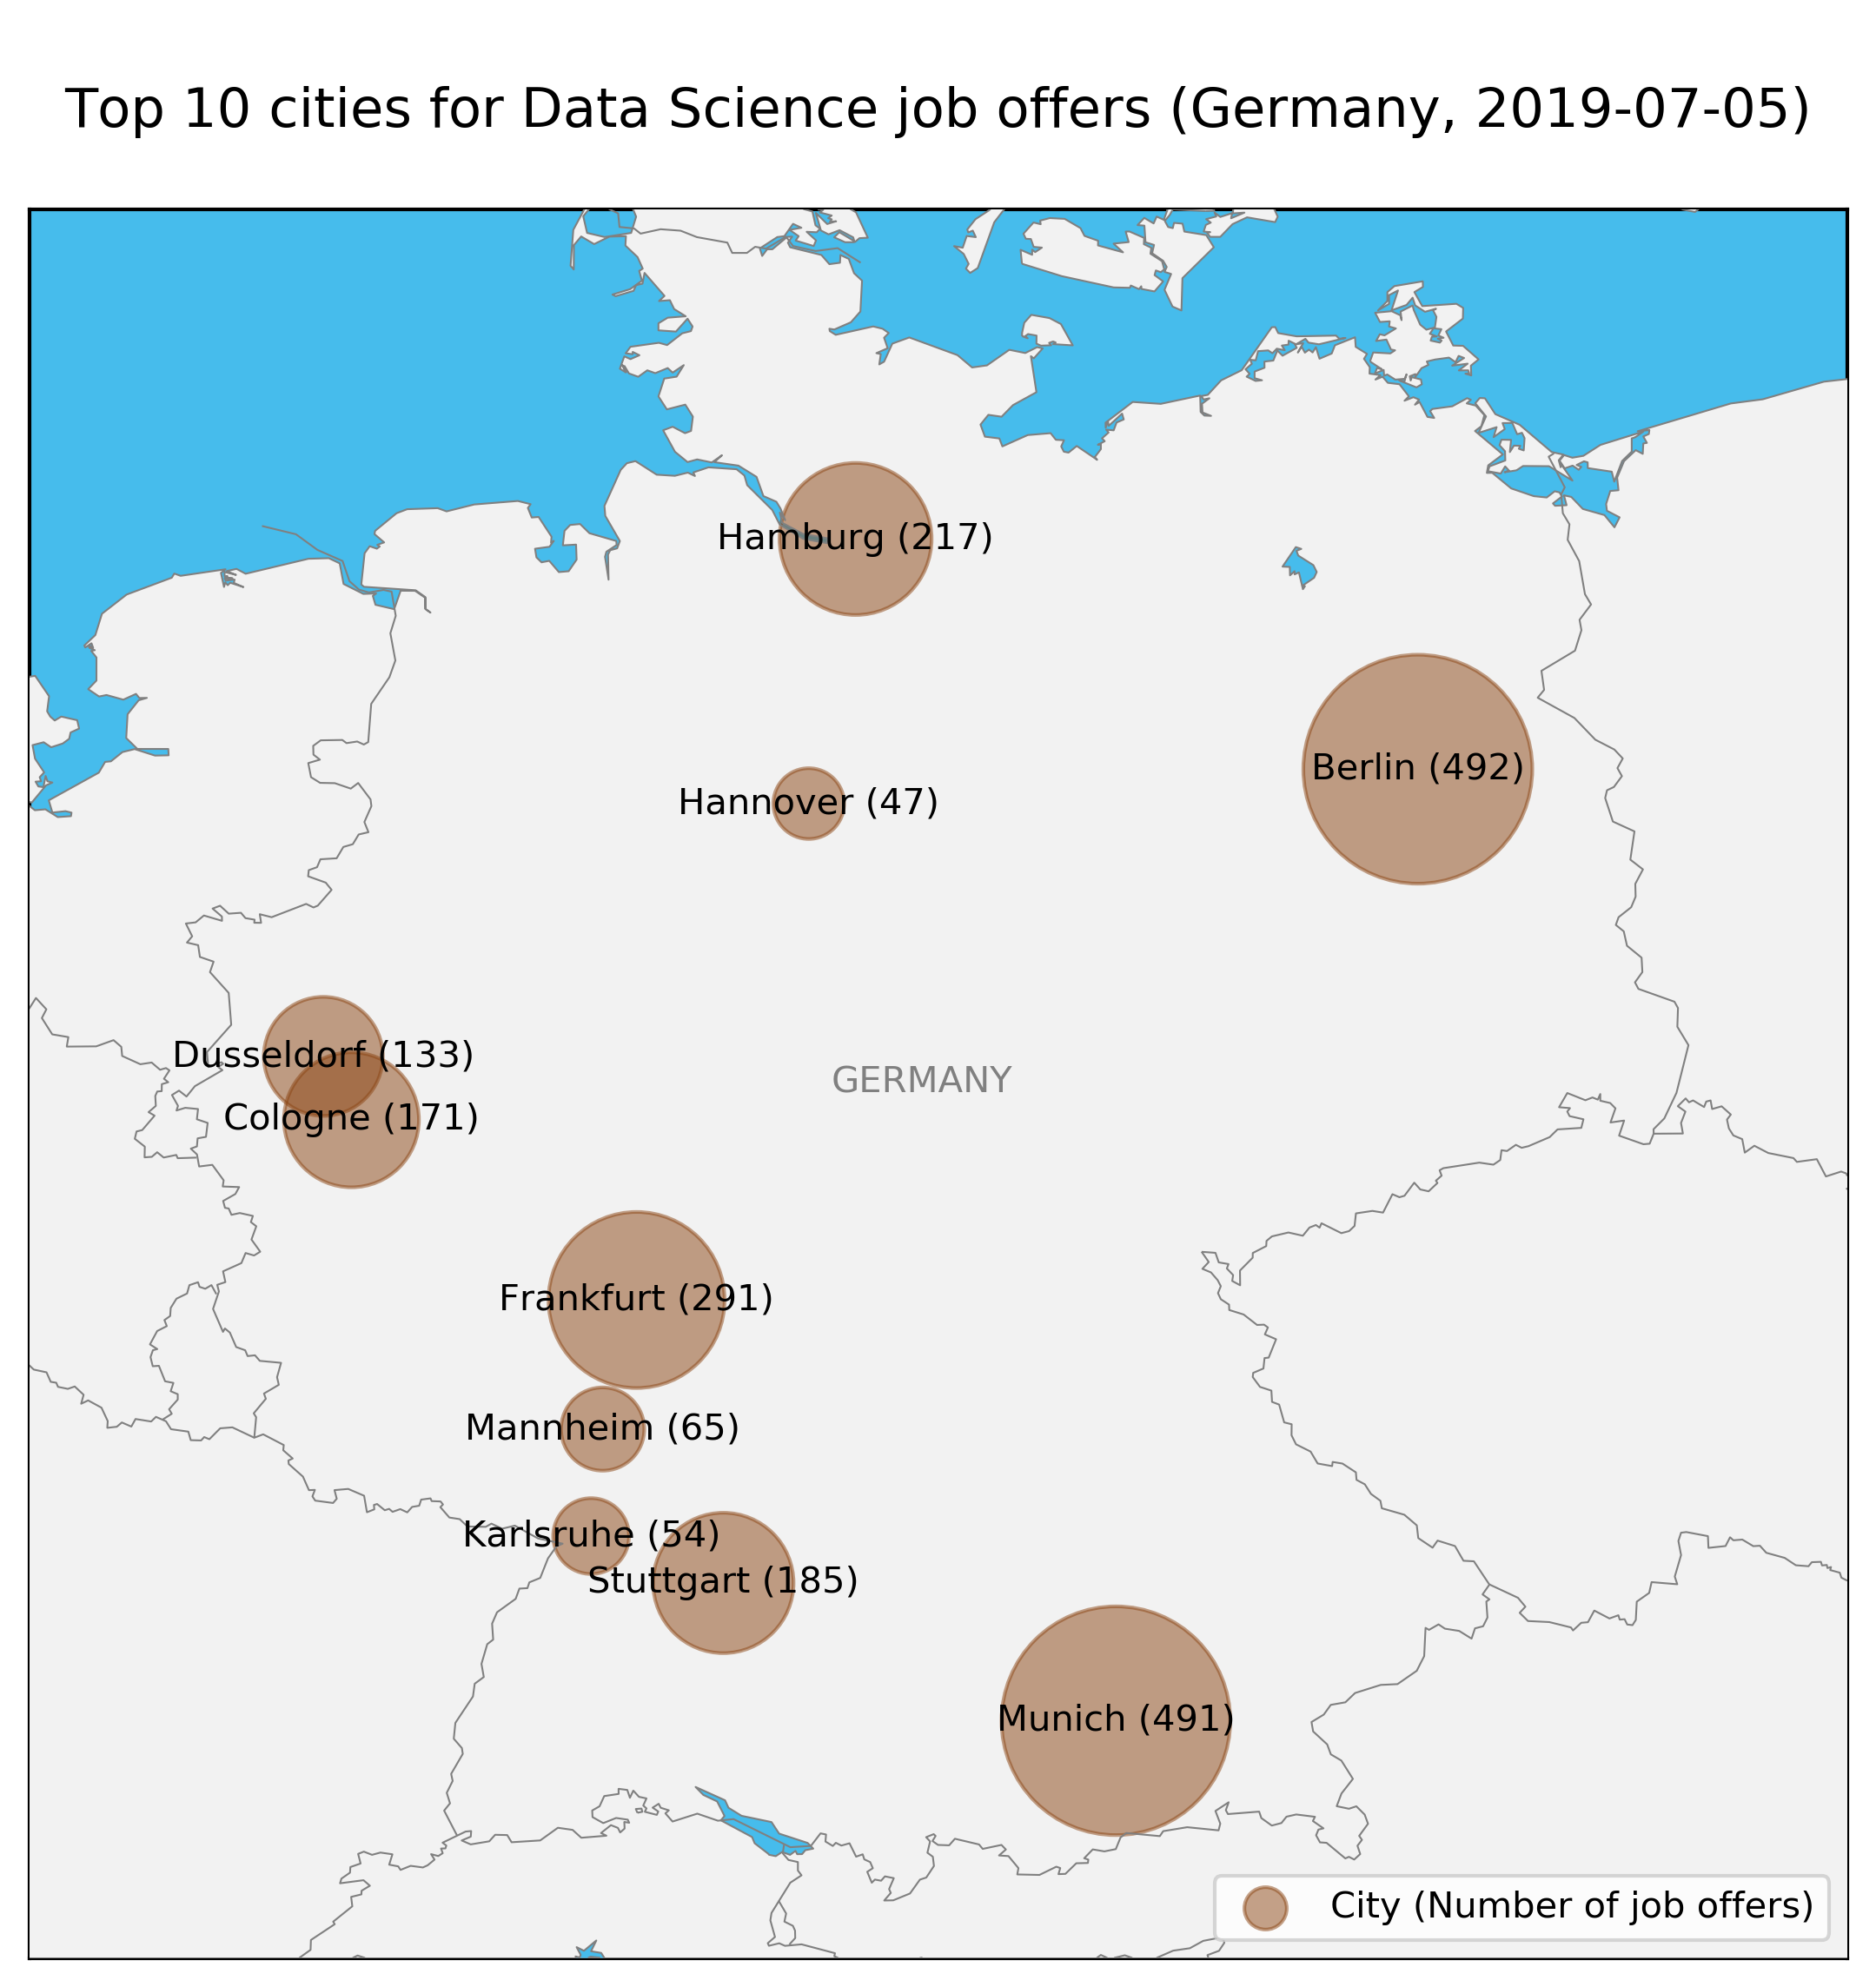

In [10]:
# VISUALISE THE TOP 10 CITIES FOR DATA SCIENCE JOB OFFERS IN GERMANY
visualise_subset(lllon=5, lllat=47, urlon=16, urlat=55, fig_width=9, fig_height=9, geo='Germany', top_n=10)

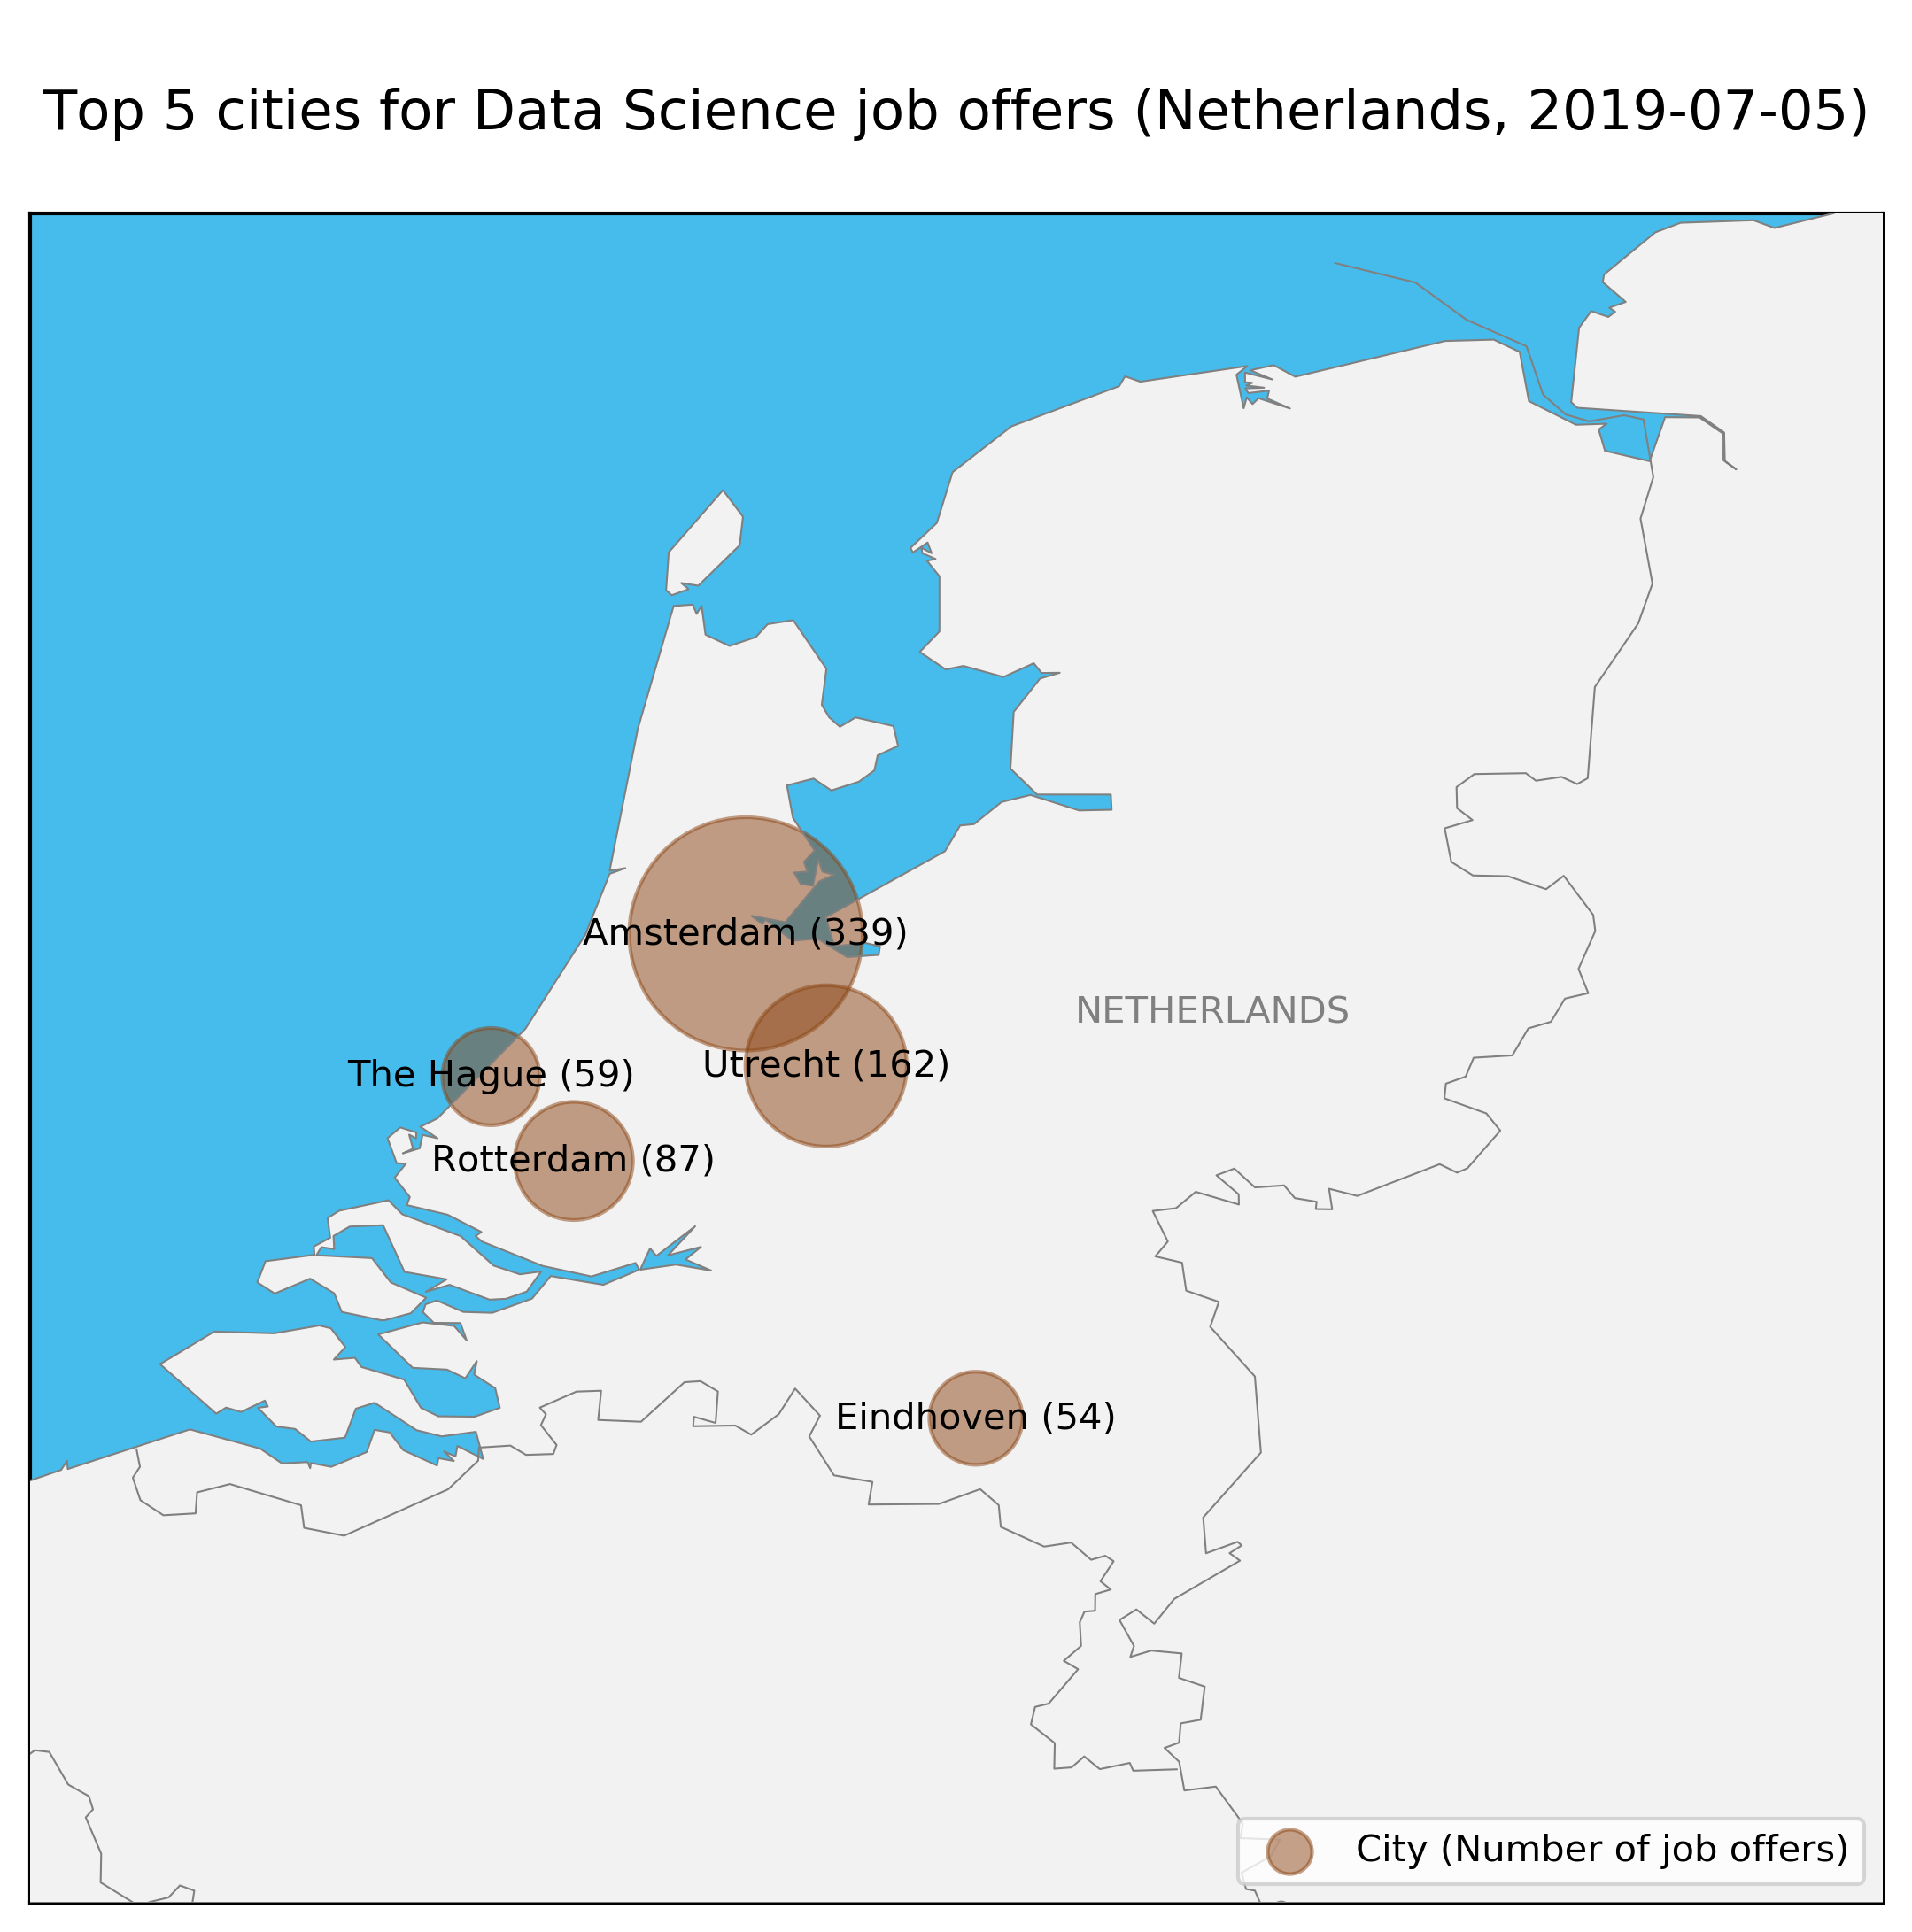

In [11]:
# VISUALISE THE TOP 5 CITIES FOR DATA SCIENCE JOB OFFERS IN THE NETHERLANDS
visualise_subset(lllon=3.1, lllat=50.5, urlon=7.8, urlat=53.7, fig_width=9, fig_height=9, geo='Netherlands', top_n=5)